In [1]:
import ee
import os
import time
import glob
import logging
import requests
import threading
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Authenticate to earth engine

ee.Authenticate()

Enter verification code:  4/1AX4XfWhPXLUyShN4-SK5APHCJUk1qPtH0rqwlU6yBzqK6TZ7didHI19E16A



Successfully saved authorization token.


In [41]:
# Initialize earth engine connection

ee.Initialize()

In [4]:
# Set destination folder paths for results and figures

results_dir = os.path.join(os.getcwd().replace('/code', ''), 'results')
fig_dir = os.path.join(os.getcwd().replace('/code', ''), 'figures')

### Import Sentinel-1 collection and watershed basin shapefile

In [5]:
# Import image and feature colelctions

s1 = ee.ImageCollection("COPERNICUS/S1_GRD")
basins = ee.FeatureCollection("users/coreyscher/se-asia_subbasin_01min")
lulc = ee.Image('users/coreyscher/all_lcmaps_v3_2018_proj')

## create a log file to track progress

logging.basicConfig(filename="logfilename.log", level=logging.INFO)

In [6]:
# LULC classes

classes = {'forest_evergreen': 2,
          'forest_decisuous': 4,
          'forest_mixed': 5,
          'water': 25,
          'urban': 13,
          'barren': 16,
          'grass': 10,
          'savannah' : 9,
          'ag_rice': 17,
          'ag_plantation': 18,
          'ag_pasture_crop': 12,
          'ag_aquaculture': 21,
          'wetland_wetland': 11,
          'wetland_mangrove': 19,
          'wetland_flooded_forest': 20,
          'unclassified': 0}

In [35]:
## Set threshold variables 

threshold = -2
vvOwThreshold = -18
vhOwThreshold = -28
connThreshold = 20

In [25]:
## Get a list of basins to iterate over

basins_ids = basins.aggregate_array('ID').getInfo()

In [32]:
# Descending track algorithm

result = None

def run_sub_basin(basin_id, studyStart, studyEnd):
    
    results = []
    studyArea = basins.filterMetadata('ID', 'equals', basin_id).first()
    
    # ----Separate S1 by orbit type ---------------------
    s1A = s1.filterBounds(studyArea.geometry())\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW')).filterDate(studyStart, studyEnd).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    s1D = s1.filterBounds(studyArea.geometry())\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW')).filterDate(studyStart, studyEnd).filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    # --------------------------------------------------------------
    
    image_dates = s1D.aggregate_array('system:time_start')
    
    # Map over images in collection and meadian window filter with 15 meter radius
    def medianFilt(image):
        return image.focalMedian(15, 'square', 'meters').clip(studyArea).copyProperties(image)
    
    ## map median filter over the input collection
    
    s1D = s1D.map(medianFilt)

    # Calculate baseline statistics for annual backscatter
    
    def minMax(pol):
        
        #Define the collection
        coll = s1D.select([pol])        
        
        #Turn the input polarization element into a string for concatenation
        
        pol = ee.String(pol)
        
        # Calculate min, max, mean, and stdDev backscatter by input polarization
        mn = coll.min().rename([pol.cat('_min')])
        mx = coll.max().rename([pol.cat('_max')])
        mean = coll.mean().rename([pol.cat('_mean')])
        std = coll.reduce(ee.Reducer.stdDev()).rename([pol.cat('_std')])
        
        #Calcaulate z score
        
        dif = mx.subtract(mn).rename([pol.cat('_dif')])
        z = dif.divide(std).rename([pol.cat('_z')])
        return mx.addBands([mn, mean, std, dif, z]).set({'pol': pol}).toFloat()
    
    # Apply minMax to each polarization in the collection
    vh_stats = minMax('VH')
    vv_stats = minMax('VV')

    # Make a z-score mask for areas that do not have a minimum two standard deviations below the mean annual backscatter
    vvZMask = vv_stats.select(['VV_z']).gt(2)
    vhZMask = vh_stats.select(['VH_z']).gt(2)
    
    # Function for defining open water on a per-image basis
    def openWaterClass(image):
        
        #set the image class for GEE
        image = ee.Image(image)
        
        #Classify each image for open water based on the fixed threshold for each polarization
        
        # Comment out co-polarized data for testing with cross-polarized only
        #vv = image.select(['VV']).lt(vvOwThreshold)
        
        vh = ee.Image(image).select(['VH']).lt(vhOwThreshold)
        
        #Construct a mask for "open water" areas that are smaller than the threshold for connected pixels
        
        vvAreaMask = vv.connectedPixelCount(1024, 'false').gt(connThreshold)
        vhAreaMask = vh.connectedPixelCount(1024, False).gt(connThreshold)

        vv = vv.updateMask(vv.neq(0)).updateMask(vvZMask).updateMask(vvAreaMask)
        vh = vh.updateMask(vh.neq(0)).updateMask(vhZMask).updateMask(vhAreaMask)

        #Make a band corresponding to each LULC class from the Boston dataset
        
        ag_rice = vh.updateMask(lulc.eq(17))
        ag_aquaculture = vh.updateMask(lulc.eq(21))
        wetland_wetland = vh.updateMask(lulc.eq(11))
        wetland_mangrove = vh.updateMask(lulc.eq(19))
        wetland_flooded_forest = vh.updateMask(lulc.eq(20))
        water = vh.updateMask(lulc.eq(25))
        
        # For now, omit the land cover classes where we wouldn't expect regular, seasonal inundation
        
        #ag_plantation = vh.updateMask(lulc.eq(18))
        #ag_pasture_crop = vh.updateMask(lulc.eq(12))
        #urban = vh.updateMask(lulc.eq(13))
        #barren = vh.updateMask(lulc.eq(16))
        #grass = vh.updateMask(lulc.eq(10))
        #savannah = vh.updateMask(lulc.eq(9))
        #forest_evergreen = vh.updateMask(lulc.eq(2))
        #forest_decisuous = vh.updateMask(lulc.eq(4))
        #forest_mixed = vh.updateMask(lulc.eq(5))
        #unclassified = vh.updateMask(lulc.eq(0))
        
        # Make a composite image of all of the landcover-inundation bands
        com = ee.Image(water.copyProperties(image)).set('system:time_start', image.get('system:time_start')) \
                .addBands(ag_rice).addBands(ag_aquaculture).addBands(wetland_wetland) \
                .addBands(wetland_mangrove).addBands(wetland_flooded_forest) \
                 .rename(['water','ag_rice', \
                        'ag_aquaculture', 'wetland_wetland', \
                        'wetland_mangrove', 'wetland_flooded_forest']) \

        
#                .addBands(wetland_mangrove).addBands(wetland_flooded_forest) #.addBands(savannah).addBands(ag_rice) \
#                 .addBands(ag_plantation).addBands(ag_pasture_crop).addBands(ag_aquaculture).addBands(wetland_wetland) \
#                 .addBands(wetland_mangrove).addBands(wetland_flooded_forest).addBands(ag_aquaculture) \
#            .rename(['forest_evergreen', 'forest_decisuous', \
#                         'forest_mixed', 'water', 'urban', 'barren', \
#                         'grass', 'savannah', 'ag_rice', 'ag_plantation', \
#                         'ag_pasture_crop', 'ag_aquaculture', 'wetland_wetland', \
#                         'wetland_mangrove', 'wetland_flooded_forest', 'unclassified'])

        
        # Reduce the image by summing the number of pixels classified as inundated across each landcover type
        
        reduced =com.reduceRegion(ee.Reducer.sum(), \
                  geometry=studyArea.geometry(), \
                  scale=100, \
                    maxPixels = 1e13)

        return reduced
    
    # Make the image collection a list and map the open water classification routine across the list
    descending = s1D.toList(s1D.size()).map(openWaterClass)
    
    #return the mapped image collection as a list and a list of dats of the image acquisitions
    return descending, image_dates


In [84]:
# This function take a basin ID as it's input and maps the above functions across each year relevant to the Sentinel-1 record
# The function saves a CSV of inundated area time series by landcover types to the local machine

def runBasin(basin_id):
    print('processing '+ str(basin_id))
    ee.Initialize()
    
    startTime = time.time()
    logging.info('basin ID '+ str(basin_id)+ ' start time: ' + str(startTime))
    
    dest_path = os.path.join(results_dir, 'basin_id_' + str(basin_id) +'.csv')
    
    
    # iterate over basin IDs and build a dataframe for each
    
    time.sleep(0.5)
    
    data_19 = run_sub_basin(basin_id, '2019-01-01', '2020-01-01')[0].getInfo()
    i_dates_19 = run_sub_basin(basin_id,  '2019-01-01', '2020-01-01')[1].getInfo()
    
    time.sleep(0.5)
    
    data = run_sub_basin(basin_id, '2018-01-01', '2019-01-01')[0].getInfo()
    i_dates = run_sub_basin(basin_id,  '2018-01-01', '2019-01-01')[1].getInfo()
    
    time.sleep(0.5)
    
    data_17 = run_sub_basin(basin_id, '2017-01-01', '2018-01-01')[0].getInfo()
    i_dates_17 = run_sub_basin(basin_id,  '2017-01-01', '2018-01-01')[1].getInfo()
    
    time.sleep(0.5)
    
    data_16 = run_sub_basin(basin_id, '2016-01-01', '2017-01-01')[0].getInfo()
    i_dates_16 = run_sub_basin(basin_id,  '2016-01-01', '2017-01-01')[1].getInfo()

    df0 = pd.DataFrame(data_19)
    df0['dates'] = pd.Series(i_dates_19)
    df1 = pd.DataFrame(data)
    df1['dates'] = pd.Series(i_dates)
    df2 = pd.DataFrame(data_17)
    df2['dates'] = pd.Series(i_dates_17)
    df3 = pd.DataFrame(data_16)
    df3['dates'] = pd.Series(i_dates_16)

    test_time_series = df3.append(df2).append(df1).append(df0)
    test_time_series['datetimes'] = pd.to_datetime(test_time_series['dates'], unit='ms')
    test_time_series.set_index('datetimes', inplace=True)
    test_time_series.drop(columns=['dates'], inplace=True)
    
    test_time_series.to_csv(dest_path)
    
    executionTime = (time.time() - startTime)
    
    logging.info('basin ID '+ str(basin_id)+ ' processed in seconds: ' + str(executionTime))
    
    print('basin ID '+ str(basin_id)+ ' processed in seconds: ' + str(executionTime))
    time.sleep(2)
    return 'completed basin id: ' + str(basin_id)


In [85]:
# Test the algorithm over the Godavari region


godavari = basins.filterMetadata('BASINNAME','equals', 'GHAASBasin9')
godavari = godavari.aggregate_array('ID').getInfo()

for i in godavari:
    runBasin(i)
    
print('Done')

processing 1911
basin ID 1911 processed in seconds: 10.747452974319458
processing 1917
basin ID 1917 processed in seconds: 7.908045291900635
processing 1984
basin ID 1984 processed in seconds: 9.04706621170044
processing 1981
basin ID 1981 processed in seconds: 6.203663110733032
processing 1930
basin ID 1930 processed in seconds: 5.953406810760498
processing 1979
basin ID 1979 processed in seconds: 6.1773340702056885
processing 1834
basin ID 1834 processed in seconds: 7.529550075531006
processing 1940
basin ID 1940 processed in seconds: 6.332738876342773
processing 1840
basin ID 1840 processed in seconds: 8.87984299659729
processing 1836
basin ID 1836 processed in seconds: 7.712238073348999
processing 1848
basin ID 1848 processed in seconds: 6.401733160018921
processing 1844
basin ID 1844 processed in seconds: 6.185077905654907
processing 1851
basin ID 1851 processed in seconds: 7.738045930862427
processing 1841
basin ID 1841 processed in seconds: 5.713710069656372
processing 1957
basi

In [86]:
# Concatenate all of the sub-basin CSV files into a single data frame

path = results_dir
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, parse_dates=['datetimes'])
    li.append(df)

# Create the combined dataframe from the list of dataframes
frame = pd.concat(li, axis=0, ignore_index=True).set_index('datetimes')

In [87]:
len(all_files)

153

In [88]:
len(godavari)

153

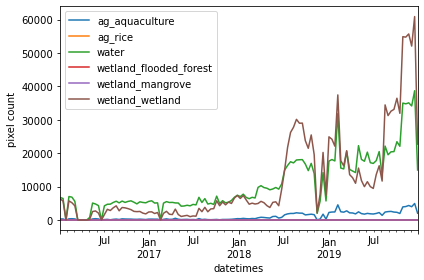

In [89]:
# Plot the results

fig, ax = plt.subplots(figsize=(6, 4))
frame.resample('12D').sum().plot(ax = ax)
ax.set_ylabel('pixel count')
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, 'example_time_series_godavari.png'), dpi=300, facecolor='white')

In [90]:
# Request WBM discharge data from the ASRC servers

url = "https://chartows.environmentalcrossroads.net/chart/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=chart:basinmouth_discharge_daily_terra-wbmsed-prist_01min&outputFormat=application/json&viewparams=date_min:2016-01-01;date_max:2019-12-31;sampleid_min:9;sampleid_max:9;"
wbm = requests.request("GET", url,)
wbm = pd.json_normalize(wbm.json()['features'])
wbm['properties.date'] = wbm['properties.date'].str.replace('Z', '')
wbm['datetimes'] = pd.to_datetime(wbm['properties.date'])
wbm.set_index('datetimes', inplace=True)

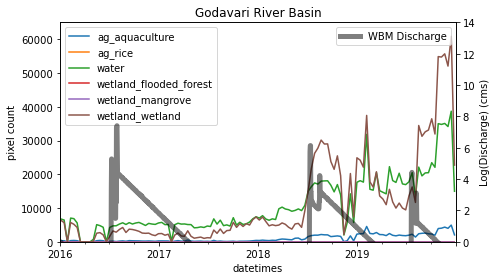

In [123]:
#Plot inundated area and discharge over time

fig, ax = plt.subplots(figsize=(7, 4))

ax2 = np.log(wbm['properties.Discharge']).plot(ax=ax, secondary_y=True, color='black', alpha= 0.5, linewidth=5)
frame.resample('12D').sum().plot(ax = ax)
ax.set_ylabel('pixel count')
ax2.set_ylabel('Log(Discharge) (cms)')
ax2.legend(['WBM Discharge'])
ax2.set_ylim(0, 14) 
ax.set_ylim(0, 65000)
plt.title('Godavari River Basin')

plt.tight_layout()

plt.savefig('godavari_S1_comparison.png', dpi=300, facecolor='white')